# 인물사진을 만들어 보자!

#### 필요한 라이브러리 선언하기!

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


#### 이미지 불러오기!

(1128, 1128, 3)


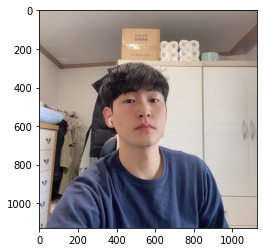

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### PixelLib에서 제공하는 모델 다운로드하기!

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fcc55207ac0>)

#### Segmantation Model 생성하기!

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#### 모델에 이미지 넣기 !

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

#### PASCAL VOC 데이터의 라벨 종류 넣어주기!

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### output 출력해보기!

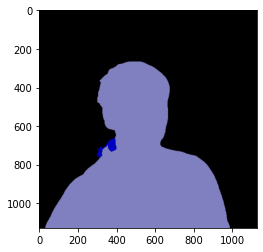

In [7]:
plt.imshow(output)
plt.show()

모델을 통해 객체를 추출했는데 각각의 다른 색상으로 담겨져 있는 것을 볼 수 있다.

In [8]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


#### ↑ 배경, 의자, 사람이라는 객체를 인식해 나타내주었다. <br/>
물체마다 output에 어떤 색상으로 나타나 있는지 알아보자!

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

#### 사람은 어떤 색상으로 나타냈는지 BGR을 한번 나타내보자!

In [11]:
colormap[15]

array([192, 128, 128])

##### output 이미지는 BGR 순서이기 때문에 colormap에 맞춰주기 위해 값 순서를 바꿔주자!

In [12]:
seg_color = (128,128,192)

#### seg_color로 이루어진 마스크를 만들어보기! (사람과 의자가 인식되었다.)

(1128, 1128)


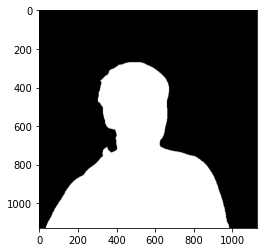

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

#### 원본 이미지와 겹쳐서 segmantation 결과 보기!

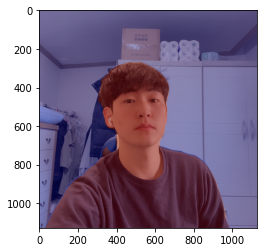

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### cv2.blur를 이용해 배경 흐리게 하기! 

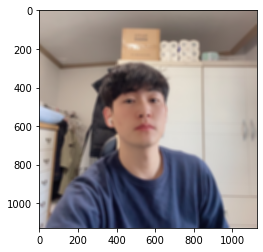

In [18]:
# (13,13)은 blurring kernel size를 뜻합니다

# 실습은 (13,13)이지만 나는 좀 더 키워보았다.
img_orig_blur = cv2.blur(img_orig, (17,17))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### segmantation mask를 이용해 흐려진 배경만 추출해보기!

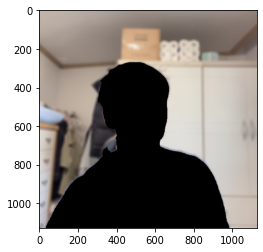

In [19]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

`bitwise_not`를 이용해 이미지가 반전되었다. <br/>
원래 마스크에서 배경은 `0`, 사람은 `255`였지만 `bitwise_not` 연산을 통해
배경`255`, 사람`0`으로 반전되었다. <br/>

반전된 segmantation 결과를 이용해 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있는 모든 픽셀은 0이 된다.

#### 윗 작업을 한 결과인 배경 이미지와 사람 이미지를 합치기!

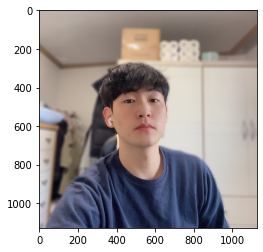

In [20]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점
 - 첫번째로는 segmantation mask와 흐린 배경과의 윤곽이 뚜렷하지 못합니다. <br/>
 문제점이 더 있는지 찾아봤지만 첫번째 말고는 못찾았다... 다른 이미지로 실습해보자!

## 두번째 이미지 실습해보기

(408, 720, 3)


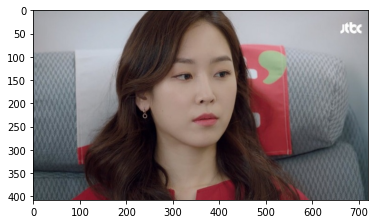

In [21]:
img_path = '/aiffel/aiffel/human_segmentation/images/seo.jfif'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 모델 로드 및 output 확인하기

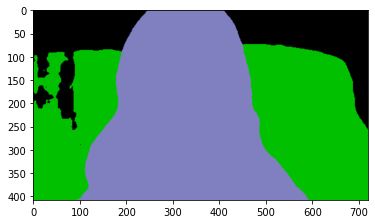

In [22]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

### 인식한 객체 확인하기

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
sofa


### 컬러맵 RGB 변경 및 seg_color 마스크 출력하기

(408, 720)


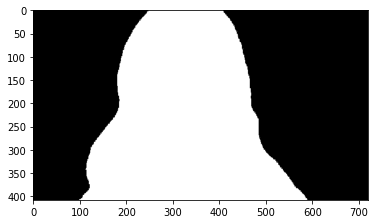

In [24]:
seg_color = (128,128,192)

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

### 원본 이미지와 겹쳐서 segmantation 결과 보기!

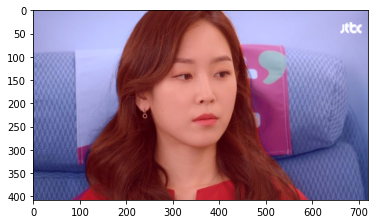

In [34]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 1.0, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이번엔 얼굴 마스크 합성할 때 비율을 1.0으로 줘보았다.

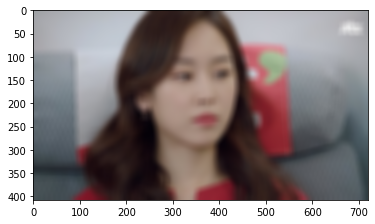

In [35]:
img_orig_blur = cv2.blur(img_orig, (17,17))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 얼굴 색상 반전 해주기

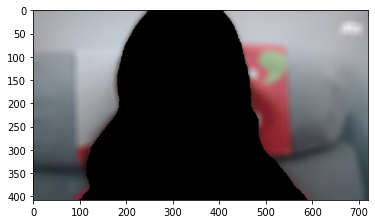

In [36]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

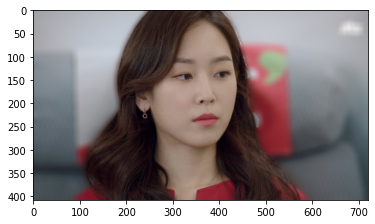

In [37]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점
 - 두번째 이미지로 실습해봤지만 여전히 윤곽이 뚜렷하지 못했다...
 - 또 다른 문제점이 생겼는데 왼쪽 머리 부분이 흐리게 나오는 상황이 발생했다...

## 응용버전: 두개의 이미지 합성해보기!

(300, 300, 3)


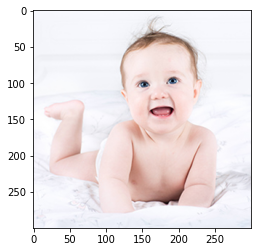

In [38]:
img_path = '/aiffel/aiffel/human_segmentation/images/baby.jpg'
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

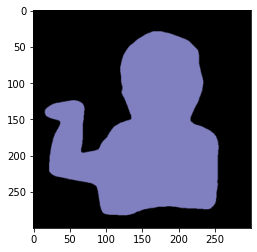

In [39]:
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [40]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [42]:
colormap[15]

array([192, 128, 128])

(300, 300)


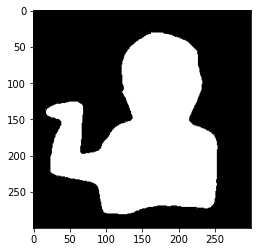

In [44]:
seg_color = (128,128,192)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

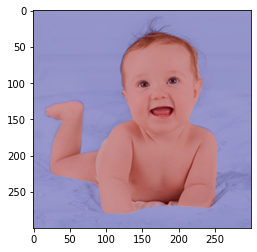

In [46]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

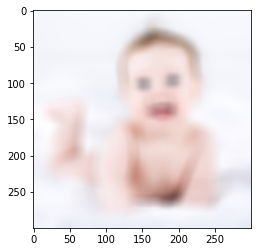

In [47]:
img_orig_blur = cv2.blur(img_orig, (17,17))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

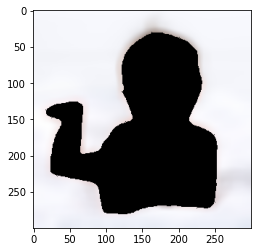

In [48]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

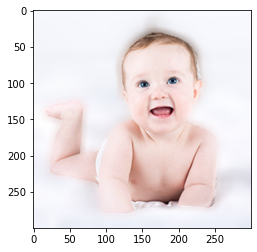

In [49]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [75]:
background_path = '/aiffel/aiffel/human_segmentation/images/background.jpg'
background_orig = cv2.imread(background_path)

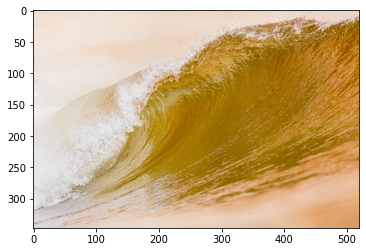

In [76]:
plt.imshow(background_orig)

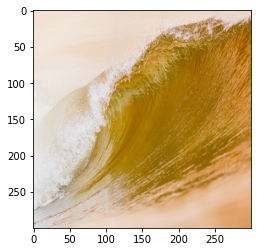

In [77]:
background_resize = cv2.resize(background_orig, dsize=(300,300))
plt.imshow(background_resize)

In [78]:
img_bg_mask.shape

(300, 300, 3)

In [79]:
background_resize.shape

(300, 300, 3)

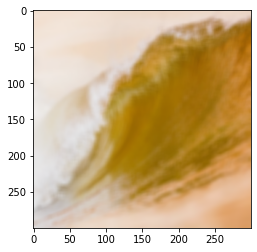

In [80]:
background_blur = cv2.blur(background_resize, (7,7))
plt.imshow(background_blur)
plt.show()

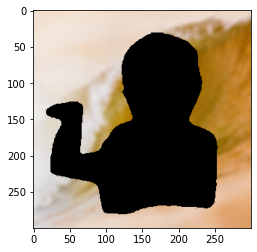

In [81]:
img_bg_blur = cv2.bitwise_and(background_blur, img_bg_mask)
plt.imshow(img_bg_blur)
plt.show()

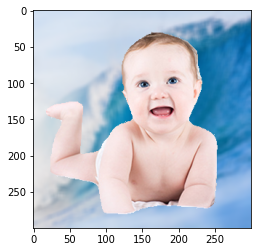

In [83]:
img_concat = np.where(img_mask_color==255, img_orig, background_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점
 - 여기에서도 문제점이 역시 있었다. 두개의 이미지를 이용해서 그런지 윤곽은 나름 잘 나타냈으나 불필요한 라인도 나타나는 것을 볼 수 있다.

##  해결방법

 - Deep deconvolution network라는 모델을 이용해 semantic segmentation 문제를 해결할 수 있다.
 - VGG-16 모델을 가져와 top layer 부분을 튜닝한 후 deconvolution, upooling layer를 추가함으로써 픽셀 단위의 정교한 prediction이 가능해지기 때문이다..